# How to use NetCore

In [5]:
import sys
sys.path.append("netcore/")
import netcore
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

## Input

NetCore requires as input two main components: a PPI network and a weight scheme for the nodes in the network. In addition, the user can provide a list of seed nodes which can be used for generating binary weights, or for the module identification step.

Here we will provide a short description of the format of the input files:

### PPI Network

The PPI network should be provided in a form of edge list, a file with two columns, where each row represents an interaction.

The PPI must be fully connected in order to apply NetCore. If that is not the case, then NetCore will extract the largest component from the network and use only the nodes and the edges in this component. The same procedure is applied when generating network permutations.

In [9]:
# open edge list file file
edge_list_file = "data/metabase.txt"
edge_list = pd.read_csv(edge_list_file,header=None,sep="\t")
#edge_list[0]=edge_list[0].apply(str)
#edge_list[1]=edge_list[1].apply(str)
#np.savetxt('test.txt', edge_list, fmt="%s", delimiter='\t')
#edge_list.to_csv("test.txt", header=None, index=None, sep=' ', mode='w')
edge_list

,0,1
0,-12862675,-1778147180
1,2241,-874081380
2,499,-768661884
3,-1702973627,-912570817
4,2494,398
...,...,...
478692,6431,-1040836692
478693,724,4387
478694,-1414333158,-1188252678
478695,-757844759,6324


In [14]:
# open edge list file file
edge_list_file = "data/CPDB_high_confidence.txt"
edge_list = pd.read_csv(edge_list_file,header=None,sep="\t")
edge_list


,0,1
0,STIM1,TRPC1
1,KCNJ11,ABCC9
2,HADHA,HADHB
3,GTF2E1,GTF2E2
4,GTF2A1,GTF2A2
...,...,...
114511,CACNA1B,STX3
114512,ITGB1,FGA
114513,GTF2B,CREB1
114514,EIF4EBP3,MTOR


#### Network permutations

NetCore applies a permutation test in the module identification step. Therefore, the files of the permutated networks are also required as input. The user can provide his own permutation files, or generate them using the ```permutations_test.py``` script.

In [6]:
from permutations_test import make_network_permutations

**Run-time memory warning:** Executing the next funtion will be executed assuming it can use 64 cores (or more). If you're running this on a computer with less cores, make sure to first change the ```num_cores``` argument accordingly. Running time for 1 permutation (with swap_factor=100) is just under 45 minutes (with one core). Therefore, it is recommented to use multiple cores and generate at least 100 permutations. This can be done once only and later be repeatedly used.

To generate permutations in a parallel fashion, the user can change the ```num_cores``` argument in the function to be larger than ```1``` and then multiple processes will be generated (as many as the number of given cores).

Use ```num_perm``` to change the number of permutations that are created.

Use ```swap_factor``` to change the number attmeps for edge swaps, wich is given by: number_of_edges X swap_factor. (For more details, please see [the documentaion page of the Networkx package](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.swap.connected_double_edge_swap.html).

The permutations files will be saved in a new sub-directory of the given output path, and will be named as the given network name with a suffix of *edge_permutations*. So in the follwoing example the sub-directory will be named *CPDB_high_confidence_edge_permutations*.

In [8]:
make_network_permutations(net_file=edge_list_file,
                          net_name="metabase_high_confidence",
                          output_path="data/",
                          num_perm=100,
                          swap_factor=100,
                          num_cores=15)

Getting network
Network without edge weights
8 nodes were removed from the network since they are not connected to the biggest component
Making Edge permutations (in parallel)


KeyboardInterrupt: 

### Node Weights

Weights for the nodes in the network should be provided in a tab-delimited file where for each node a numeric value is given. The names of the nodes should match their names in the edge list file. Not all the nodes in the network must be in the file. The ones that are missing will automatically recieve a weight of ```0```. Nodes that are given a weight but are not included in the edge list file will be ignored.

In [6]:
weights_file = "data/Type_2_diabetes_score.txt"
weights = pd.read_csv(weights_file,header=None,sep='\t')
weights.head()

,0,1
0,MARCH1,5.045757
1,PCNX2,6.397940
2,LPIN2,5.045757
3,DCDC2C,5.522879
4,HUNK,5.397940


In [7]:
len(weights[0].unique())

1450

(array([1.389e+03, 3.900e+01, 7.000e+00, 7.000e+00, 4.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  5.04575749,  21.29346962,  37.54118174,  53.78889387,
         70.03660599,  86.28431812, 102.53203024, 118.77974237,
        135.02745449, 151.27516662, 167.52287875]),
 <BarContainer object of 10 artists>)

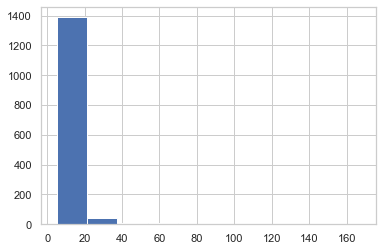

In [8]:
plt.hist(weights[1])

### Seed Nodes

A file with seed nodes, which is optional to provide, can be used in the following ways:

1. For the module identification step - the seed nodes will be used to generate the initial modules.
2. For binary weights - in case a weights file is not provided, binay weights will be generated such that the seed nodes will have a weight of ```1```.

In [9]:
seed_file="data/Type_2_diabetes.txt"
seed = pd.read_csv(seed_file,header=None)
seed

,0
0,ABO
1,ACSL1
2,ADAM30
3,ADAMTS9
4,ADCY5
...,...
119,ZBED3
120,ZFAND3
121,ZFAND6
122,ZMIZ1


In [10]:
len(seed[0].unique())

124

## Running NetCore

NetCore requiers at least 3 inputs:

* An edge list file for the network
* A weights file for some or all the nodes in the network. In case such file is not avilable than a seed file can be used
* A path for the directory containing all of the permutaions of the network

Running NetCore with the input files will generate two outputs:

* ```random_walk_weights.txt``` - a propagation weights file with re-ranking of the nodes in the network according to their weights after the propagation
* ```subnetworks.txt``` - a list of the modules found
* ```extended_seed_subnet``` - a .txt file with the edge list of the seed induced sub-network that was extended to include more nodes based on the propagation results, along with a pdf file that contains the figure of the sub-network
* ```modules``` - a sub-directory with figures of the modules found

### Running via the command line

**Run-time memory warning:** NetCore is computes the fractional power of a matrix using [scipy](http://lagrange.univ-lyon1.fr/docs/scipy/0.17.1/generated/scipy.linalg.fractional_matrix_power.html) which might take long and be intesive to process. It is recommened to use a machine with at least 64 cores. 

On a computer with 64 cores, with 100 permutations, the total running time of NetCore is just under 60 min. Using more permutations will increase the running time in ~30 seconds for each permutation.

To run NetCore the ```netcore.py``` script must be executed using ```python3``` with at least 4 arguments. The user can chose to input either a weights file or a seed file (or both), but at least one must be provided. 

#### Requiered arguments

``` -pd``` : The path to the directory where the permutation files of the network are stored

``` -e``` : Network file in an edge list format

``` -w``` : Weights file for some or all nodes in the network

*and/or*

``` -s``` : Seed file with seed nodes for binary propagation and/or module identification


In [13]:
%run netcore.py \
        -e data/CPDB_high_confidence.txt \
        -w data/Type_2_diabetes_score.txt \
        -s data/Type_2_diabetes.txt \
        #-pd data/CPDB_high_confidence_edge_permutations/ \
        -o data/result/

usage: netcore.py [-h] -e EDGE_LIST [-w WEIGHTS_FILE] [-s SEED_FILE]
                  [-p RESTART_PROB] [-n NORMALISATON_METHOD] -pd PERMUT_DIR
                  [-pn PERM_NAME] [-np NUM_PERMUTATIONS] [-nn NET_NAME]
                  [-pt PVAL_THRESH] [-wt WEIGHT_THRESH] [-ms MAX_SUBNET_SIZE]
                  -o OUTPUT_DIR
netcore.py: error: the following arguments are required: -pd/--permut_dir


SystemExit: 2

In [12]:
node_deg = G_connected.degree()

NameError: name 'G_connected' is not defined

In [18]:
G_connected = random_walk_with_restart.edges_to_net(edge_list)

NameError: name 'random_walk_with_restart' is not defined

In [20]:
edge_list

,0,1
0,STIM1,TRPC1
1,KCNJ11,ABCC9
2,HADHA,HADHB
3,GTF2E1,GTF2E2
4,GTF2A1,GTF2A2
...,...,...
114511,CACNA1B,STX3
114512,ITGB1,FGA
114513,GTF2B,CREB1
114514,EIF4EBP3,MTOR


In [21]:
def make_network(edge_list):

    print("Getting network information...")

	G_connected, removed_nodes, is_edge_weights , vertex_index = edges_to_net(edge_list)

	# order the nodes
	nodes_order = sorted(G_connected.nodes())

	# get the adjacency matrix of the graph, ordered accodring to the nodes
	adj_mat = nx.adjacency_matrix(G_connected,nodelist=nodes_order)
	adj_mat_dense = adj_mat.todense()

	# get the node degree and k-shell
	node_deg = G_connected.degree()
	node_deg_order = np.array([node_deg[n] for n in nodes_order])
	node_core = nx.core_number(G_connected)
	node_core_order = np.array([node_core[n] for n in nodes_order])

	return vertex_index, G_connected, adj_mat_dense , nodes_order , node_deg_order , node_core_order, removed_nodes, is_edge_weights


In [43]:
vertex_index, G_connected, adj_mat_dense , nodes_order , node_deg_order , node_core_order, removed_nodes, is_edge_weights  = make_network(edge_list)

Getting network information...


TypeError: argument of type 'method' is not iterable

In [25]:
edges = pd.DataFrame(
    {
        "source": [0, 1, 2],
        "target": [2, 2, 3],
        "weight": [3, 4, 5],
        "color": ["red", "blue", "blue"],
    }
)

In [26]:
edges

,source,target,weight,color
0,0,2,3,red
1,1,2,4,blue
2,2,3,5,blue


In [37]:
edge_list = edge_list.rename(columns={0: 'source', 1: 'target'})

In [38]:
edge_list

,source,target
0,STIM1,TRPC1
1,KCNJ11,ABCC9
2,HADHA,HADHB
3,GTF2E1,GTF2E2
4,GTF2A1,GTF2A2
...,...,...
114511,CACNA1B,STX3
114512,ITGB1,FGA
114513,GTF2B,CREB1
114514,EIF4EBP3,MTOR


In [39]:
G = nx.from_pandas_edgelist(edge_list, edge_attr=True)

NetworkXError: Invalid edge_attr argument: No columns found with name: []

In [24]:
G=nx.from_pandas_edgelist(edge_list)

KeyError: 'source'

### NetCore output files

#### NetCore propagation weights and p-values

The first output file contains the propagation weights for all the nodes in the network and their pvalues (based on the permutation test).
The file is sorted according to weights after propagation and pvalues.

In [6]:
# open propagaion weights file
netcore_weights_file = "data/result/random_walk_weights.txt"
netcore_weights = pd.read_csv(netcore_weights_file,sep="\t")
netcore_weights.head()


,node_index,node,prop_weight,pvalue
0,4635,KCNQ1,84.231641,0.009901
1,3991,HLA-DQA1,42.138332,0.009901
2,3993,HLA-DQB1,39.481334,0.009901
3,3534,GMCL1,18.611808,0.009901
4,506,APP,17.961043,0.009901


#### NetCore modules

NetCore outputs the modules and the genes in each module in a `text` file, as well as plots the modules and outputs them as `pdf` files.

In addition, Netcore provides the extended seed sub-network, which inclues all of the seed nodes and the nodes that were added after the propagation. For this sub-network both an edge list and an adjecency list are are provided, as well as a `pdf` with the plot of the sub-network. 

In [8]:
# open the modules file
netcore_modules_file = "data/result/core_norm_subnetworks.txt"
netcore_modules = pd.read_csv(netcore_modules_file,sep=",")
netcore_modules.head()


,nodes,size,sum_weights
0,ABCC8\tACHE\tADCY5\tANK2\tAP2M1\tAPOE\tAPP\tAT...,50,531.788
1,GIT2\tHMG20A\tHMGA2\tJAZF1\tPOU5F1\tPPARG\tPRM...,8,87.384
2,HNF1A\tHNF1B\tHNF4A\tJAG1\tNOTCH2,5,44.987
3,HLA-B\tLAMTOR3\tPSMD6\tSND1\tSSR1\tTOMM40,6,23.330
4,GRK5\tMAEA\tRBMS1,3,20.942


In [9]:
# to get the nodes in each module
for nodes in netcore_modules.nodes:
    nodes_list = nodes.split("\t")
    print(nodes_list)

['ABCC8', 'ACHE', 'ADCY5', 'ANK2', 'AP2M1', 'APOE', 'APP', 'ATP4A', 'ATP6V0A1', 'BCCIP', 'CD74', 'CDH4', 'CFTR', 'DDX19B', 'FAF1', 'FTO', 'GNAI3', 'GPSM1', 'GRB14', 'GRB2', 'HLA-DQA1', 'HLA-DQB1', 'IDE', 'IGF1R', 'INS', 'IRS1', 'KCNJ11', 'KCNJ8', 'KCNK16', 'KCNQ1', 'LAMA1', 'MTNR1B', 'MYO19', 'NDRG1', 'NPEPPS', 'PRKACA', 'PRKAR2A', 'PTPRD', 'PTPRS', 'R3HDML', 'SCN2B', 'SH3GL2', 'SLC3A2', 'SPRY2', 'SYVN1', 'UBE2E2', 'UBXN7', 'USP2', 'VPS26A', 'WFS1']
['GIT2', 'HMG20A', 'HMGA2', 'JAZF1', 'POU5F1', 'PPARG', 'PRMT6', 'YEATS4']
['HNF1A', 'HNF1B', 'HNF4A', 'JAG1', 'NOTCH2']
['HLA-B', 'LAMTOR3', 'PSMD6', 'SND1', 'SSR1', 'TOMM40']
['GRK5', 'MAEA', 'RBMS1']
['GMCL1', 'PAX4']
['CREB3L1', 'RTN3', 'SLC30A8']
['SGCD', 'SGCG']
['DPP4', 'GIP']


In [12]:
# get the extended seed subnetwork
extended_seed_subnet_adjlist = "data/result/extended_seed_subnet.adjlist"
extended_seed_subnet = nx.read_adjlist(extended_seed_subnet_adjlist, create_using = nx.Graph(),
                nodetype = str)
print("Extended seed sub-network:")
print("Number of nodes " + str(extended_seed_subnet.number_of_nodes()))
print("Number of edges " + str(extended_seed_subnet.number_of_edges()))

Extended seed sub-network:
Number of nodes 117
Number of edges 92


In [15]:
# show the biggest module
from IPython.display import IFrame
module0_file = "data/result/modules/module0.pdf"
IFrame(module0_file, width=600, height=300)

### Optional arguments (and their default values)

Set the dirctory for output files (if not give, default is the current directory) 

``` -o path ```

Set the **restart probability** for the random walk with restart process by:

``` -p 0.5```


Set the **normalization method** of the adjecency matrix in the network propagation by:

``` -n core_norm```

Set the prefix and the suffix for the name of the **permutations files** (which is generated by the *permutations_test.py* script) by:

```-nn CPDB_high_confidence```

```-pn edgelist```

Set the **number of permutations** to use by:
    
```-np 100```

Set the **thresholds** for the **pvalue** and **weight** for the module identification step (if a weight thershold is not given, it will be calculated according to the propagation weights):

```-pt 0.01```

```-wt None```

Set the **maximum size** of the extended seed sub-network by (if no value is given the maximum size is calculated according size of the seed induced sub-network)

``` -ms None```

## Weighted networks

NetCore also allows the usage of weighted networks.

The input should include, in addition to the edge list, a weight for every edge in the network.

The adjecency matrix normalizaion methods have been adapted for the weighted case, such that the edge weights are also used for normalizing the adjecency matrix, in addition to the degree or core or both.

In addition, for the permutation test, it is possible to create network permutations using the `make_network_permutations.py` script. The input file should also include the edge weights. The edge swapping implementation from the `Networkx` package has been modified to also swap the edge weights.
